In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Load the dataset
file_path = 'user_journey_raw.csv'  # Replace with your file name
data = pd.read_csv(file_path)

# Inspect the first few rows
print(data.head())
print(data.info())

   user_id  session_id subscription_type  \
0     1516     2980231            Annual   
1     1516     2980248            Annual   
2     1516     2992252            Annual   
3     1516     3070491            Annual   
4     1516     3709807            Annual   

                                        user_journey  
0  Homepage-Log in-Log in-Log in-Log in-Log in-Lo...  
1  Other-Sign up-Sign up-Sign up-Sign up-Sign up-...  
2          Log in-Log in-Log in-Log in-Log in-Log in  
3  Homepage-Log in-Log in-Log in-Log in-Log in-Lo...  
4  Log in-Log in-Log in-Log in-Log in-Log in-Log ...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9935 entries, 0 to 9934
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            9935 non-null   int64 
 1   session_id         9935 non-null   int64 
 2   subscription_type  9935 non-null   object
 3   user_journey       9935 non-null   object
dtypes: int64(2),

In [4]:
# Function to remove sequential duplicates in user journeys
def remove_page_duplicates(data, target_column='user_journey'):
    def clean_journey(journey):
        pages = journey.split('-')
        cleaned_pages = [pages[0]]
        for page in pages[1:]:
            if page != cleaned_pages[-1]:
                cleaned_pages.append(page)
        return '-'.join(cleaned_pages)
    
    # Apply the cleaning function
    data[target_column] = data[target_column].apply(clean_journey)
    return data

# Apply the function to clean user_journey
cleaned_data = remove_page_duplicates(data, target_column='user_journey')

# Inspect cleaned data
print(cleaned_data.head())


   user_id  session_id subscription_type           user_journey
0     1516     2980231            Annual  Homepage-Log in-Other
1     1516     2980248            Annual   Other-Sign up-Log in
2     1516     2992252            Annual                 Log in
3     1516     3070491            Annual        Homepage-Log in
4     1516     3709807            Annual                 Log in


In [5]:
# Function to group user journeys
def group_by(data, group_column='user_id', target_column='user_journey', sessions='All', count_from='last'):
    grouped_data = data.copy()
    if sessions != 'All':
        if count_from == 'last':
            grouped_data = grouped_data.groupby(group_column).tail(sessions)
        elif count_from == 'first':
            grouped_data = grouped_data.groupby(group_column).head(sessions)
    
    grouped_data = grouped_data.groupby(group_column)[target_column].apply(lambda x: '-'.join(x)).reset_index()
    grouped_data.columns = [group_column, target_column]  # Rename columns
    return grouped_data

# Apply the function to group user journeys by user_id
grouped_data = group_by(cleaned_data, group_column='user_id', target_column='user_journey', sessions='All')

# Inspect the grouped data
print(grouped_data.head())


   user_id                                       user_journey
0     1516  Homepage-Log in-Other-Other-Sign up-Log in-Log...
1     3395  Other-Pricing-Sign up-Log in-Homepage-Pricing-...
2    10107  Homepage-Homepage-Career tracks-Homepage-Caree...
3    11145  Homepage-Log in-Homepage-Log in-Homepage-Log i...
4    12400  Homepage-Career tracks-Sign up-Log in-Other-Ca...


In [6]:
# Function to remove specific pages
def remove_pages(data, pages, target_column='user_journey'):
    def filter_pages(journey):
        return '-'.join([page for page in journey.split('-') if page not in pages])
    
    # Apply the filter function
    data[target_column] = data[target_column].apply(filter_pages)
    return data

# Specify pages to remove
pages_to_remove = ['Log in', 'Sign up']

# Apply the function to filter user journeys
filtered_data = remove_pages(grouped_data, pages=pages_to_remove, target_column='user_journey')

# Inspect the filtered data
print(filtered_data.head())


   user_id                                       user_journey
0     1516  Homepage-Other-Other-Homepage-Checkout-Checkou...
1     3395  Other-Pricing-Homepage-Pricing-Pricing-Checkou...
2    10107  Homepage-Homepage-Career tracks-Homepage-Caree...
3    11145  Homepage-Homepage-Homepage-Homepage-Homepage-H...
4    12400  Homepage-Career tracks-Other-Career track cert...


In [7]:
# Define the output file path
output_file = 'cleaned_user_journeys.csv'

# Export the filtered data to a CSV file
filtered_data.to_csv(output_file, index=False)

print(f"Cleaned data exported to {output_file}")


Cleaned data exported to cleaned_user_journeys.csv


QUESTION 1 :How many records are in the data if you group only the first three sessions?    


In [8]:
# Group data by 'user_id' and take only the first three sessions for each user
first_three_sessions = data.groupby('user_id').head(3)

# Get the count of records
record_count = len(first_three_sessions)

print(f"Number of records when grouped by the first three sessions: {record_count}")


Number of records when grouped by the first three sessions: 3575


Question 2: What is the 3rd most popular page for quarterly users?

In [9]:
# Filter data for quarterly users
quarterly_data = data[data['subscription_type'] == 'Quarterly']

# Flatten user journeys to a list of pages
pages_quarterly = '-'.join(quarterly_data['user_journey']).split('-')

# Create a series and count occurrences
quarterly_page_counts = pd.Series(pages_quarterly).value_counts()

# Get the 3rd most popular page
third_most_popular = quarterly_page_counts.index[2]

print(f"The 3rd most popular page for quarterly users is: {third_most_popular}")


The 3rd most popular page for quarterly users is: Checkout


Question 3: What is the 4th most popular page after the user has been on Pricing?

In [10]:
def find_page_after_pricing(journey):
    pages = journey.split('-')
    next_pages = []
    for i, page in enumerate(pages):
        if page == 'Pricing' and i < len(pages) - 1:
            next_pages.append(pages[i + 1])
    return next_pages

next_pages = []
for journey in data['user_journey']:
    next_pages.extend(find_page_after_pricing(journey))

fourth_popular = pd.Series(next_pages).value_counts().index[3]

print(fourth_popular)

Log in


QUESTION 4: What is the average length of a user journey if you consider just the last three sessions?

In [11]:
# Step 1: Get the last three sessions for each user
last_three_sessions = data.groupby('user_id').tail(3)

# Step 2: Create a function to count pages in a journey
def count_journey_pages(journey):
    # Split the journey by '-' and count unique pages
    pages = journey.split('-')
    return len(pages)

# Step 3: Calculate journey lengths and average
journey_lengths = last_three_sessions['user_journey'].apply(count_journey_pages)
average_length = journey_lengths.mean()

print(f"The average journey length is: {average_length:.1f}")

The average journey length is: 1.6


QUESTION 5: What is the page with the 4th highest presence in the last three sessions of journeys (not the absolute number of page visits


In [12]:
last_three = group_by(data, group_column='user_id', target_column='user_journey', sessions=3, count_from='last')
all_pages = []
for journey in last_three['user_journey']:
    all_pages.extend(journey.split('-'))
fourth_highest = pd.Series(all_pages).value_counts().index[3]

print(f"The page with the 4th highest presence in the last three sessions is: {fourth_highest}")


The page with the 4th highest presence in the last three sessions is: Homepage


##### Question 6: In how many journeys is the most popular sequence of 4 pages encountered?

In [13]:
# First, let's get only the last 3 sessions for each user
last_three_sessions = data.groupby('user_id').tail(3)

# Function to get all possible 4-page sequences from a journey
def get_4_page_sequences(journey):
    pages = journey.split('-')
    if len(pages) < 4:  # If journey is less than 4 pages, return empty list
        return []
    sequences = []
    for i in range(len(pages) - 3):
        sequence = '-'.join(pages[i:i+4])
        sequences.append(sequence)
    return sequences

# Get all sequences from all journeys
all_sequences = []
for journey in last_three_sessions['user_journey']:
    sequences = get_4_page_sequences(journey)
    all_sequences.extend(sequences)

# Count occurrences of each sequence
from collections import Counter
sequence_counts = Counter(all_sequences)

# Get the count of the most common sequence
most_common_count = sequence_counts.most_common(1)[0][1]

print(f"The most popular 4-page sequence appears in {most_common_count} journeys")

The most popular 4-page sequence appears in 30 journeys


## visualization of the data

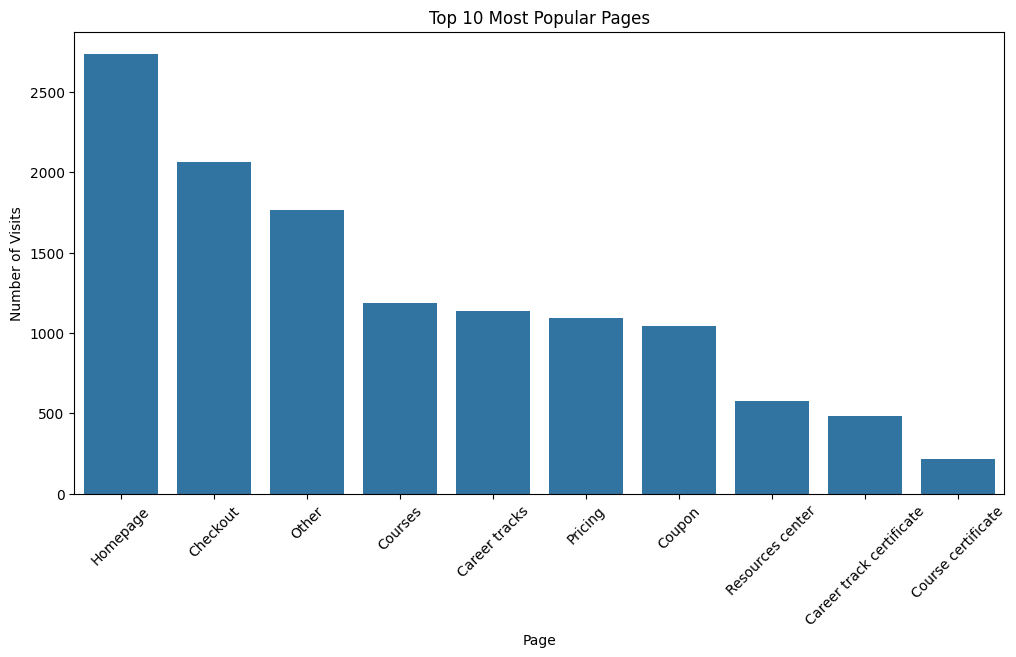

In [14]:
# Load cleaned data
data = pd.read_csv('cleaned_user_journeys.csv')

# Drop rows with missing user_journey values
data = data.dropna(subset=['user_journey'])

# Ensure all entries in 'user_journey' are strings
data['user_journey'] = data['user_journey'].astype(str)

# Flatten all user journeys into a list of pages
all_pages = '-'.join(data['user_journey']).split('-')

# Create a pandas series to count the occurrence of each action
page_counts = pd.Series(all_pages).value_counts().reset_index()
page_counts.columns = ['page', 'count']

# Plot the most popular pages
plt.figure(figsize=(12, 6))
sns.barplot(x='page', y='count', data=page_counts.head(10))
plt.title('Top 10 Most Popular Pages')
plt.xticks(rotation=45)
plt.xlabel('Page')
plt.ylabel('Number of Visits')
plt.show()
